In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import pearsonr

In [3]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, RFE
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, \
    roc_auc_score, roc_curve

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1 Grow Up data

In [21]:
election_data = pd.read_csv('election_data.csv', dtype = {'fips_code': str})
election_data = election_data.rename(columns={'fips_code':'fips'})
print(election_data.shape)
print(election_data.head())

(3112, 20)
    fips              county  total_2008  dem_2008  gop_2008  oth_2008  \
0  26041        Delta County       19064      9974      8763       327   
1  48295     Lipscomb County        1256       155      1093         8   
2  01127       Walker County       28652      7420     20722       510   
3  48389       Reeves County        3077      1606      1445        26   
4  56017  Hot Springs County        2546       619      1834        93   

   total_2012  dem_2012  gop_2012  oth_2012  total_2016  dem_2016  gop_2016  \
0       18043      8330      9533       180       18467      6431     11112   
1        1168       119      1044         5        1322       135      1159   
2       28497      6551     21633       313       29243      4486     24208   
3        2867      1649      1185        33        3184      1659      1417   
4        2495       523      1894        78        2535       400      1939   

   oth_2016 2008_result  2008_dem_ratio  2012_dem_ratio  2016_dem_rat

## 2 Census data

In [8]:
census = pd.read_csv('data/cencus_preprocessed.csv', dtype = {'fips': str})
census_dictionary = pd.read_csv('data/dictionary.csv')

In [9]:
census.shape

(3220, 126)

In [10]:
census.head()

,fips,B992705002,B992705003,B11001002,B11001003,B11001004,B11001005,B11001006,B11001007,B11001008,...,B18101034,B18101035,B18101036,B18101037,B18101038,B18101039,B23020001,B23020002,B23020003,B01003001
0,01001,0.098892,0.901108,0.707894,0.560986,0.146908,0.032820,0.114088,0.292106,0.260426,...,0.047388,0.020214,0.027174,0.032084,0.019826,0.012258,0.655395,0.648120,0.705773,0.005446
1,01003,0.108337,0.891663,0.657126,0.527879,0.129248,0.034978,0.094269,0.342874,0.304310,...,0.060429,0.014119,0.046310,0.040895,0.018569,0.022326,0.636071,0.636090,0.675978,0.020123
2,01005,0.099674,0.900326,0.657273,0.435752,0.221521,0.027853,0.193668,0.342727,0.319443,...,0.063020,0.020063,0.042956,0.044071,0.032196,0.011875,0.619968,0.610526,0.666667,0.002593
3,01007,0.105386,0.894614,0.766628,0.580249,0.186379,0.037594,0.148785,0.233372,0.214286,...,0.046125,0.009585,0.036540,0.042086,0.022333,0.019754,0.645733,0.648120,0.670391,0.002234
4,01009,0.116979,0.883021,0.739923,0.584050,0.155872,0.058096,0.097777,0.260077,0.240213,...,0.056182,0.014544,0.041638,0.038212,0.017917,0.020295,0.658615,0.654135,0.700186,0.005706


## 3 Model

### 1) 2012 result

In [23]:
fips_class = election_data
fips_class['y'] = 0
fips_class.loc[fips_class['2012_result']=='dem', 'y'] = 1 ## target
fips_class = fips_class[['fips', 'y']]

In [24]:
fips_class['y'].value_counts()

0    2426
1     686
Name: y, dtype: int64

In [25]:
X = census.merge(fips_class.loc[:, ['fips', 'y']])
X = X.sample(X.shape[0], replace=False).reset_index(drop=True)
X = X.loc[~X.duplicated(), :].reset_index(drop=True)
X = X.set_index('fips')
y = X['y']

In [26]:
X.head()

,B992705002,B992705003,B11001002,B11001003,B11001004,B11001005,B11001006,B11001007,B11001008,B11001009,...,B18101035,B18101036,B18101037,B18101038,B18101039,B23020001,B23020002,B23020003,B01003001,y
fips,,,,,,,,,,,,,,,,,,,,,
49045,0.079889,0.920111,0.799663,0.645282,0.154381,0.055158,0.099223,0.200337,0.174215,0.026122,...,0.007118,0.020052,0.018066,0.009915,0.008151,0.619968,0.633083,0.636872,0.006269,0
13167,0.099550,0.900450,0.655783,0.450717,0.205066,0.049435,0.155630,0.344217,0.324382,0.019835,...,0.016435,0.035696,0.035277,0.027217,0.008060,0.657005,0.645113,0.675978,0.000970,0
08027,0.170080,0.829920,0.703774,0.640229,0.063545,0.022456,0.041089,0.296226,0.260392,0.035834,...,0.015583,0.093722,0.056768,0.024711,0.032057,0.587762,0.562406,0.651769,0.000446,0
18025,0.082605,0.917395,0.676316,0.516346,0.159970,0.066384,0.093586,0.323684,0.276516,0.047167,...,0.025066,0.030289,0.036270,0.020984,0.015287,0.632850,0.648120,0.638734,0.001049,0
19087,0.083186,0.916814,0.675116,0.516598,0.158518,0.056999,0.101518,0.324884,0.271616,0.053268,...,0.012342,0.039055,0.047123,0.022707,0.024416,0.634461,0.622556,0.690875,0.001966,0


In [27]:
audit = pd.DataFrame({'columns':[], 'ref_mean':[], 'ref_std':[], 'tgt_mean':[], 'tgt_std':[], 'ratio':[], 'ztest':[]})
for i in range(0,X.shape[1]-1):
    col = X.columns[i]
    ref_cnt = X.loc[X['y']==0].shape[0]
    ref_mean = X.loc[X['y']==0, col].mean()
    ref_std = X.loc[X['y']==0, col].std()
    tgt_mean = X.loc[X['y']==1, col].mean()
    tgt_std = X.loc[X['y']==1, col].std()
    tgt_cnt = X.loc[X['y']==1].shape[0]
    ratio = tgt_mean/ref_mean
    sigma = np.sqrt(ref_std*tgt_std/ref_cnt + ref_std*tgt_std/tgt_cnt)
    ztest = np.abs(ref_mean-tgt_mean)/sigma
    audit = audit.append(pd.DataFrame({'columns':[col], 'ref_mean':[ref_mean], 'ref_std':[ref_std], 'tgt_mean':[tgt_mean], 'tgt_std':[tgt_std], 'ratio':[ratio], 'ztest':[ztest]}))

In [28]:
census_dictionary.merge(audit).sort_values('ztest', ascending=False).to_csv('audit_report_v1.csv', index=False)

In [29]:
X = X.loc[:, [c for c in X.columns if c not in ['y']]]
X.shape

(3111, 125)

In [30]:
idx = np.arange(X.shape[0])
np.random.seed(1234)
train_idx = X.index[np.random.choice(idx, int(X.shape[0]/2), replace=False)]
test_idx = np.setdiff1d(X.index, train_idx)

In [31]:
cross_val_score(GradientBoostingClassifier(), X, y, 
               scoring='roc_auc', cv=5, n_jobs=5)

array([0.91864167, 0.89987207, 0.89907442, 0.90852585, 0.90462789])

In [32]:
class_model = GradientBoostingClassifier().fit(
    X.loc[train_idx,:], y[train_idx])

In [33]:
class_true = y[test_idx]
class_prob = class_model.predict_proba(X.loc[test_idx, :])[:,1]
roc_auc_score(class_true, class_prob)

0.9017875202265373

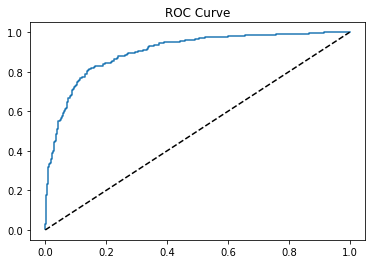

In [34]:
curve = roc_curve(class_true, class_prob)
plt.plot(curve[0], curve[1])
plt.title('ROC Curve')
plt.plot([0,1], [0,1], color='black', linestyle='--')

In [35]:
importance = pd.DataFrame(list(zip(X.columns, class_model.feature_importances_)),
             columns=('columns', 'class_importance'))
importance = importance.merge(census_dictionary)
importance = importance.merge(audit[['columns', 'ref_mean', 'tgt_mean', 'ratio', 'ztest']])

In [37]:
importance.sort_values('class_importance', ascending=False).head(10)

,columns,class_importance,description,table,ref_mean,tgt_mean,ratio,ztest
3,B11001003,0.106665,Family households: Married-couple family,Household Type (Including Living Alone),0.526802,0.456461,0.866476,25.189718
6,B11001006,0.050706,Family households: Other family: Female househ...,Household Type (Including Living Alone),0.104375,0.136702,1.309712,16.855658
9,B11001009,0.041711,Nonfamily households: Householder not living a...,Household Type (Including Living Alone),0.046897,0.063321,1.350222,15.325887
114,B18101033,0.039491,Female: 35 to 64 years: No disability,Sex by Age by Disability Status,0.165359,0.170166,1.029068,6.086081
122,B23020002,0.035671,Male,Mean Usual Hours Worked in the Past 12 Months ...,0.642377,0.614195,0.956128,19.283082
124,B01003001,0.027156,Total,Total Population,0.005721,0.026000,4.544321,15.372356
121,B23020001,0.025065,Total:,Mean Usual Hours Worked in the Past 12 Months ...,0.637961,0.618238,0.969083,17.068993
70,B19001005,0.024685,"$20,000 to $24,999",Household Income in the Past 12 Months (In 201...,0.060451,0.056493,0.934524,5.256075
78,B19001013,0.023691,"$75,000 to $99,999",Household Income in the Past 12 Months (In 201...,0.119756,0.115610,0.965379,3.581198
112,B18101031,0.022054,Female: 35 to 64 years:,Sex by Age by Disability Status,0.197742,0.199395,1.008363,2.252355


In [45]:
importance.loc[importance['table']=='Household Income in the Past 12 Months (In 2017 Inflation-adjusted Dollars)']

,columns,class_importance,description,table,ref_mean,tgt_mean,ratio,ztest
67,B19001002,0.018138,"Less than $10,000",Household Income in the Past 12 Months (In 201...,0.074694,0.085667,1.146910,6.533392
68,B19001003,0.002381,"$10,000 to $14,999",Household Income in the Past 12 Months (In 201...,0.060428,0.062023,1.026393,1.496217
69,B19001004,0.003830,"$15,000 to $19,999",Household Income in the Past 12 Months (In 201...,0.059863,0.057805,0.965628,2.278557
70,B19001005,0.024685,"$20,000 to $24,999",Household Income in the Past 12 Months (In 201...,0.060451,0.056493,0.934524,5.256075
71,B19001006,0.009207,"$25,000 to $29,999",Household Income in the Past 12 Months (In 201...,0.056972,0.052366,0.919149,7.119753
72,B19001007,0.000781,"$30,000 to $34,999",Household Income in the Past 12 Months (In 201...,0.057063,0.052045,0.912060,8.279653
73,B19001008,0.007591,"$35,000 to $39,999",Household Income in the Past 12 Months (In 201...,0.052003,0.047401,0.911505,8.452745
74,B19001009,0.009553,"$40,000 to $44,999",Household Income in the Past 12 Months (In 201...,0.051177,0.047153,0.921369,7.962935
75,B19001010,0.001430,"$45,000 to $49,999",Household Income in the Past 12 Months (In 201...,0.044719,0.040829,0.913005,8.602145
76,B19001011,0.011444,"$50,000 to $59,999",Household Income in the Past 12 Months (In 201...,0.084271,0.077647,0.921395,9.824904


In [38]:
importance.sort_values('class_importance', ascending=False).to_csv('class_model_importance_v1.csv', index=False)

In [39]:
class_prob_all = pd.DataFrame({'fips': X.index, 'score':class_model.predict_proba(X)[:,1]})
class_prob_all.head()

,fips,score
0,49045,0.028644
1,13167,0.020872
2,08027,0.023253
3,18025,0.021331
4,19087,0.047429


### validate on 2016 election result

In [40]:
fips_class['y_val'] = 0
fips_class.loc[election_data['2016_result']=='dem', 'y_val'] = 1
fips_class_val = class_prob_all.merge(fips_class.loc[:, ['fips', 'y_val']])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
fips_class['y_val'].value_counts()

0    2625
1     487
Name: y_val, dtype: int64

In [42]:
roc_auc_score(fips_class_val['y_val'], fips_class_val['score'])

0.9571318832059574

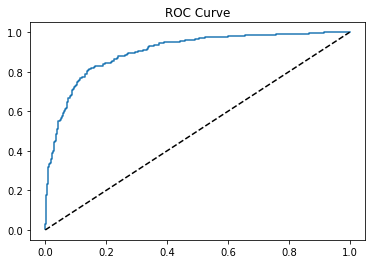

In [43]:
curve = roc_curve(class_true, class_prob)
plt.plot(curve[0], curve[1])
plt.title('ROC Curve')
plt.plot([0,1], [0,1], color='black', linestyle='--')